In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [ ]:
# deciding the transformes to apply to the dataset
transform = transforms.Compose( [transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:

batch_size = 32
 
# Downloading the training set of CIFAR10 dataset, and getting a trainloader
trainset    = torchvision.datasets.CIFAR10(root='./data', 
                                           train=True,
                                           download=True, 
                                           transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2)
 
# Downloading the test set of CIFAR10 dataset, and getting a testloader
testset    = torchvision.datasets.CIFAR10(root='./data', 
                                          train=False,
                                          download=True, 
                                          transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size,
                                         shuffle=False, 
                                         num_workers=2)

# specifying the classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 
           'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# image.shape = [batch, channels, height, width]
print(images.shape)    

torch.Size([32, 3, 32, 32])


In [ ]:
# As specified in the paper, 
# l = number of tokens
# c = channels, 
l, c = 16, 64

In [ ]:
class Tokenizer(nn.Module):

  def __init__(self, device, L):
    super().__init__()
 
    self.L = L

    # Getting image features through layers of convolution
    # convolutional Layer 1
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
    self.mxp1  = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # convolutional Layer 2
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=1)
    self.mxp2  = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # convolutional Layer 3
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.mxp3  = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # convolutional Layer 4
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1)
    self.mxp4  = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # convolutional Layer 5
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
    self.mxp5  = nn.MaxPool2d(kernel_size=2,  stride=2)
    
    # The fully connected layers to get tokens
    self.fc1   = nn.Linear(512, L, bias=False)
    
  def forward(self, x):
    
      # x = [batch, channels, heigth, width]
      x = self.conv1(x)
      x = self.mxp1(x)
      x = F.relu(x)
 
      x = self.conv2(x)
      # x = self.mxp2(x)
      x = F.relu(x)
 
      x = self.conv3(x)
      x = self.mxp3(x)
      x = F.relu(x) 

      x = self.conv4(x)
      # x = self.mxp4(x)
      x = F.relu(x) 

      x = self.conv5(x)
      x = self.mxp5(x)
      x = F.relu(x)                          # x = [batch, C, heigth, width]
 
      x = x.view(x.shape[0], x.shape[1], -1) # x = [batch, C, heigth*width]
      
      x1 = x.permute(0,2,1)                  # x1 = [batch, H*W, C]
      x2 = x.permute(0,2,1)                  # x2 = [batch, H*W, C]
 
      x1 = self.fc1(x1)                      # x1 = [batch, H*W, L]
      x1 = x1.permute(0,2,1)                 # x1 = [batch, L, H*W]
 
      x1 = F.softmax(x1, dim=-1)
      t = torch.matmul(x1,x2)                # t = [batch, L, C]

      return t, x

In [ ]:
# As specified in the paper, 
# l = number of tokens,
# c = channels
class Recurrent_tokenizer(nn.Module):

  def __init__(self, device, l, c):
    
    super().__init__()
    self.device = device

    # get weights from previous token
    self.token2wt = nn.Linear(c, c, bias=False)
    
  def forward(self, x, token):
    
    # token = [batch, L, C]
    # X = [batch, C, H*W]

    Wr = self.token2wt(token) #Wr = [batch, L, C]
    Wr = Wr.permute(0,2,1)    #Wr = [batch, C, L]
    
    x = x.permute(0,2,1)      #x = [batch, H*W, C]

    a = torch.matmul(x,Wr)    #a = [batch, H*W, C] x [batch, C, L] = [batch, H*W, L]
    a = a.permute(0,2,1)      #a = [batch, L, H*W]
    a = F.softmax(a, dim=-1)

    t = torch.matmul(a,x)     #t = [batch, L, H*W] x  [batch, H*W, C] = [batch, L, C]

    return t

In [ ]:
class Transformer(nn.Module):

  def __init__(self, l, c):

    super().__init__()
    
    self.token2Q = nn.Linear(c,c,bias=False)
    self.token2K = nn.Linear(c,c,bias=False)

    self.F1 = nn.Conv1d(in_channels=c,out_channels=c,kernel_size=1)
    self.F2 = nn.Conv1d(in_channels=c,out_channels=c,kernel_size=1)
 
  def forward(self, token):

    # getting the key and query weights
    Tk = self.token2K(token)
    Tq = self.token2Q(token)
    Tq = Tq.permute(0,2,1)

    a = torch.matmul(Tk,Tq)
    a = F.softmax(a,dim=-1)
    a = torch.matmul(a,token)

    T = token + a          #T = [batch, l, c]
    T = T.permute(0,2,1)

    T1 = self.F1(T)
    T1 = F.relu(T1)
    T1 = self.F2(T1)
    T1 = T1 + T            #T1 = [batch, l, c]
    T1 = T1.permute(0,2,1) #T1 = [batch, c, l]

    return T1

In [ ]:
class Classifier(nn.Module):

  def __init__(self, l, c):

    super().__init__()
    self.c = c
    self.l = l
    
    self.avgPool = nn.AvgPool1d(kernel_size=3,stride=1)
    self.fc1     = nn.Linear((l-2)*c,512)
    self.fc2     = nn.Linear(512,10)
 
  def forward(self,x):  
    
    # x = [batch, l, c]

    x = x.permute(0,2,1)             # x = [batch, c, l]    
    x = self.avgPool(x)

    x = x.permute(0,2,1)
    x = x.reshape(x.shape[0],-1)     # x = [batch, c*l]

    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
   
    return x                         

In [ ]:
# Get the 1st token
tokenizer = Tokenizer(device='cuda', L=16)

# pass the consecutive tokens to recurrent tokenizer
recurrent_tokenizer1 = Recurrent_tokenizer(device='cuda', l=16, c=512)
recurrent_tokenizer2 = Recurrent_tokenizer(device='cuda', l=16, c=512)
recurrent_tokenizer3 = Recurrent_tokenizer(device='cuda', l=16, c=512)
recurrent_tokenizer4 = Recurrent_tokenizer(device='cuda', l=16, c=512)

# Transformer for the final token
transformer = Transformer(l=16, c=512)

# Final classification
classifier = Classifier(l=16, c=512)

In [ ]:
class DaMixer(nn.Module):

  def __init__(self,tokenizer, recurrent_tokenizer1, 
               recurrent_tokenizer2, recurrent_tokenizer3, 
               recurrent_tokenizer4, transformer, classifier):
    
    super().__init__()
    self.tokenizer = tokenizer

    self.recurrent_tokenizer1 = recurrent_tokenizer1
    self.recurrent_tokenizer2 = recurrent_tokenizer2
    self.recurrent_tokenizer3 = recurrent_tokenizer3
    self.recurrent_tokenizer4 = recurrent_tokenizer4

    self.transformer = transformer
    
    self.classifier = classifier
 
  def forward(self, x):

    t, features = self.tokenizer(x)

    t = self.recurrent_tokenizer1(features,t)
    t = self.recurrent_tokenizer2(features,t)
    t = self.recurrent_tokenizer3(features,t)
    t = self.recurrent_tokenizer4(features,t)

    t = self.transformer(t)
    op = self.classifier(t)

    return op

In [ ]:
model = DaMixer(tokenizer,recurrent_tokenizer1, recurrent_tokenizer2, 
                recurrent_tokenizer3, recurrent_tokenizer4, transformer, 
                classifier).to('cuda')
print(model)

DaMixer(
  (tokenizer): Tokenizer(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (mxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (mxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (mxp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (mxp4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (mxp5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=512, out_features=16, bias=False)
  )
  (recurrent_tokenizer1): Recurrent_tokenizer(
    (token2wt): Linear(in_features=512, out_features=512, bias=False)
  )
  (recurrent_tokenizer

In [ ]:
# Get number of parameters in tabular form
from prettytable import PrettyTable

def count_parameters(model):

    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0

    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
      
    print(table)
    print(f"Total Trainable Params: {total_params}")
    
    return total_params
    
count_parameters(model)

+--------------------------------------+------------+
|               Modules                | Parameters |
+--------------------------------------+------------+
|        tokenizer.conv1.weight        |    432     |
|         tokenizer.conv1.bias         |     16     |
|        tokenizer.conv2.weight        |    1024    |
|         tokenizer.conv2.bias         |     64     |
|        tokenizer.conv3.weight        |   73728    |
|         tokenizer.conv3.bias         |    128     |
|        tokenizer.conv4.weight        |   32768    |
|         tokenizer.conv4.bias         |    256     |
|        tokenizer.conv5.weight        |  1179648   |
|         tokenizer.conv5.bias         |    512     |
|         tokenizer.fc1.weight         |    8192    |
| recurrent_tokenizer1.token2wt.weight |   262144   |
| recurrent_tokenizer2.token2wt.weight |   262144   |
| recurrent_tokenizer3.token2wt.weight |   262144   |
| recurrent_tokenizer4.token2wt.weight |   262144   |
|      transformer.token2Q.w

7070602

In [ ]:

import matplotlib.pyplot as plt

# Train the network for classification
def train(train_iterator, optimizer, criterion, model, EPOCHS):

  model.train()
  epoch_loss = []
  x_list = []

  for i in range(EPOCHS):

    acc=0
    for n,data in enumerate(train_iterator):

      images, labels = data                # images = [batch, c, height, width]
                                           # labels = [batch]
      images = images.to('cuda')
      labels = labels.to('cuda')

      optimizer.zero_grad()
      output = model(images)               # output = [batch, classes]

      loss = criterion(output,labels)
      loss.backward()
      optimizer.step()

      acc+=loss.item()
      
    epoch_loss.append(acc/(n+1))
    x_list.append(i+1)

    if i%10==0:
      print("Epoch : {} | Loss : {}".format(i, epoch_loss[-1]))

  plt.plot(x_list, epoch_loss)
  plt.show()

  return epoch_loss

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.CrossEntropyLoss()

Epoch : 0 | Loss : 1.6937650166790377
Epoch : 10 | Loss : 0.4257059591516652
Epoch : 20 | Loss : 0.07439357585301093
Epoch : 30 | Loss : 0.04514172839273649
Epoch : 40 | Loss : 0.02666192329607645
Epoch : 50 | Loss : 0.025301044028955305
Epoch : 60 | Loss : 0.023128898299315553
Epoch : 70 | Loss : 0.017903911687267734
Epoch : 80 | Loss : 0.01541719901894232
Epoch : 90 | Loss : 0.013450883309585843


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9759b0b90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9759b0b90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch : 100 | Loss : 0.013086103334825117
Epoch : 110 | Loss : 0.012371785295847582
Epoch : 120 | Loss : 0.009608134788765469
Epoch : 130 | Loss : 0.010478851536691813
Epoch : 140 | Loss : 0.009485929846671794
Epoch : 150 | Loss : 0.00916315113315443
Epoch : 160 | Loss : 0.01060256454297172
Epoch : 170 | Loss : 0.006988117932003493
Epoch : 180 | Loss : 0.009289736553557398
Epoch : 190 | Loss : 0.00776273763094086


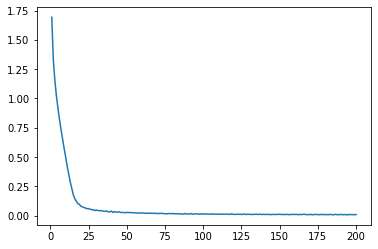

In [ ]:
loss = train(trainloader, optimizer, criterion, model, 200)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        # print(images.shape)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 74 %
